In [2]:
# Standard
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Utils
import h5py
from scipy.ndimage.morphology import binary_opening
import SimpleITK as sitk
import cv2

import tensorflow as tf

# User defined
sys.path.insert(0, "../")
from architectures.laddernet import LadderNet
from architectures.unet import UNet
from metrics.multiclass_dice import multiclass_dice, dice_lv, dice_la, dice_myo

In [3]:
# Cargamos las segmentaciones de LadderNet
p = h5py.File("../../data/laddernet1_segmentations.hdf5", "r")
segmentations = p["2ch laddernet segmentations"][:,:,:]

# Nos quedamos solo con ventrículo
segmentations = np.where(segmentations==3, 0, segmentations)

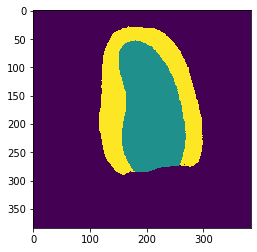

In [4]:
plt.imshow(segmentations[0])

In [5]:
def relative_bbox(img, margin=0.05):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    
    ymin = max(y1-int(margin*img.shape[1]), 0)
    ymax = min(y2+int(margin*img.shape[1]), img.shape[1])
    xmin = max(x1-int(margin*img.shape[0]), 0)
    xmax = min(x2+int(margin*img.shape[0]), img.shape[0])
    
    ymin_rel = ymin/img.shape[1]
    ymax_rel = ymax/img.shape[1]
    xmin_rel = xmin/img.shape[0]
    xmax_rel = xmax/img.shape[0]
    
    return ymin_rel, ymax_rel, xmin_rel, xmax_rel

In [6]:
# Obtenemos las coordenadas relativas de las cajas para todas las imágenes
coordinates = []
for i in range(segmentations.shape[0]):
    image_bbox = relative_bbox(segmentations[i])
    coordinates.append(image_bbox)

coordinates[0] # ymin, ymax, xmin, xmax

(0.026041666666666668,
 0.8020833333333334,
 0.2552083333333333,
 0.8255208333333334)

In [7]:
def mhd_to_array(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

In [8]:
train_2ch_frames_list = sorted(os.listdir("../../data/training/2ch/frames/"))
train_2ch_masks_list = sorted(os.listdir("../../data/training/2ch/masks/"))

In [9]:
x = mhd_to_array(os.path.join("../../data/training/2ch/frames/" + train_2ch_frames_list[0]))
x.shape

(1, 778, 549)

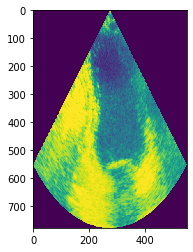

In [10]:
plt.imshow(x[0])

In [11]:
coordinates[0]

(0.026041666666666668,
 0.8020833333333334,
 0.2552083333333333,
 0.8255208333333334)

In [12]:
train_path = "../../data/training/"

In [13]:
v = h5py.File("../../data/attention_image_dataset.hdf5", "w")

v.create_dataset("attention train 2ch frames", (900, 384, 384, 1),
                chunks = (4, 384, 384, 1), dtype = "float32")

v.create_dataset("attention train 2ch masks", (900, 384, 384, 1),
                chunks = (4, 384, 384, 1), dtype = "int32")

<HDF5 dataset "attention train 2ch masks": shape (900, 384, 384, 1), type "<i4">

In [14]:
j = 0
for i in train_2ch_frames_list:
    if "mhd" in i:
        array = mhd_to_array(os.path.join(train_path, "2ch/frames", i))
        new_array = array/255
        new_array = new_array[:,int(coordinates[j][0]*array.shape[1]):int(coordinates[j][1]*array.shape[1]), int(coordinates[j][2]*array.shape[2]):int(coordinates[j][3]*array.shape[2])]
        new_array = cv2.resize(new_array[0,:,:], dsize=(384, 384), interpolation=cv2.INTER_CUBIC)
        new_array = np.reshape(new_array,(384,384,1))
        v["attention train 2ch frames"][j,...] = new_array[...]
        j = j + 1   
        
j = 0
for i in train_2ch_masks_list:
    if "mhd" in i:
        array = mhd_to_array(os.path.join(train_path, "2ch/masks", i))
        new_array = array[:,int(coordinates[j][0]*array.shape[1]):int(coordinates[j][1]*array.shape[1]), int(coordinates[j][2]*array.shape[2]):int(coordinates[j][3]*array.shape[2])]
        new_array = cv2.resize(new_array[0,:,:], dsize=(384, 384), interpolation=cv2.INTER_NEAREST)
        new_array = np.reshape(new_array,(384,384,1))
        #new_array = np.where(new_array==3, 0, new_array)
        v["attention train 2ch masks"][j,...] = new_array[...]
        j = j + 1 
        
v.close()

In [15]:
new_array.shape

(384, 384, 1)

In [16]:
v = h5py.File("../../data/attention_image_dataset.hdf5", "r")

In [17]:
b = v["attention train 2ch frames"][1]
c = v["attention train 2ch masks"][1]

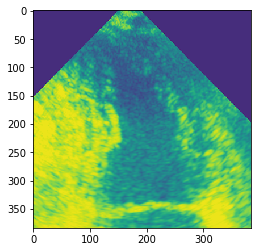

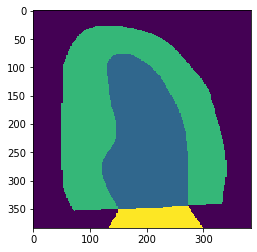

In [18]:
plt.imshow(b[:,:,0])
plt.show()
plt.imshow(c[:,:,0])
plt.show()